# Orthogonal Projections

We will write functions that will implement orthogonal projections.

## Learning objectives

1. Write code that projects data onto lower-dimensional subspaces.
2. Understand the real world applications of projections.

In [34]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import numpy.testing as npt
from ipywidgets import interact


### Testing numerical algorithms

Testing machine learning algorithms (or numerical algorithms in general)
is sometimes really hard as it depends on the dataset
to produce an answer, and you will never be able to test your algorithm on all the datasets
we have in the world. Nevertheless, there are best practices to identify bugs in implementations.

#### 1. Test on small dataset
Test your algorithms on small dataset: datasets of size 1 or 2 sometimes will suffice. This
is useful because you can (if necessary) compute the answers by hand and compare them with
the answers produced by the computer program you wrote. In fact, these small datasets can even have special numbers,
which will allow you to compute the answers by hand easily.

#### 2. Find invariants
Invariants refer to properties of your algorithm and functions that are maintained regardless
of the input. We will highlight this point later in this notebook where you will see functions,
which will check invariants for some of the answers you produce.

Invariants you may want to look for:
1. Does your algorithm always produce a positive/negative answer, or a positive definite matrix?
2. If the algorithm is iterative, do the intermediate results increase/decrease monotonically?
3. Does your solution relate with your input in some interesting way, e.g. orthogonality? 

Finding invariants is hard, and sometimes there simply isn't any invariant. However, DO take advantage of them if you can find them. They are the most powerful checks when you have them.

In [69]:
def test_property_projection_matrix(P):
    """Test if the projection matrix satisfies certain properties.
   
    1. The projection matrix is symmetric, i.e P = P.T
    
    2. Assuming the projection subspace has an orthonormal basis B, then P @ P = P
       We have:
       P @ P = (B @ B.T) @ (B @ B.T) => 
       P @ P = B @ (B.T @ B) @ B.T =>
       P @ P = B @ I @ B.T =>
       P @ P = B @ B.T
       P @ P = P
    """
    eps = np.finfo(np.float64).eps
    npt.assert_allclose(P @ P, P, atol=1000*eps)
    npt.assert_allclose(P, P.T, atol=1000*eps)


def test_property_projection(x, p):
    """Test orthogonality of x and its projection p."""
    eps = np.finfo(np.float64).eps
    npt.assert_allclose(p.T @ (p - x), 0, atol=1000*eps)
    

## Orthogonal Projections

For the projection of a vector $\boldsymbol x$ onto a 1-dimensional subspace $U$ with basis vector $\boldsymbol b$ we have

$${\pi_U}(\boldsymbol x) = \frac{\boldsymbol b\boldsymbol b^T}{{\lVert\boldsymbol  b \rVert}^2}\boldsymbol x $$

And for the general projection onto an M-dimensional subspace $U$ with basis vectors $\boldsymbol b_1,\dotsc, \boldsymbol b_M$ we have

$${\pi_U}(\boldsymbol x) = \boldsymbol B(\boldsymbol B^T\boldsymbol B)^{-1}\boldsymbol B^T\boldsymbol x $$

where

$$\boldsymbol B = [\boldsymbol b_1,...,\boldsymbol b_M]$$


In [29]:
def projection_matrix_1d(b):
    """Compute the projection matrix onto the space spanned by `b`
    Args:
        b: ndarray of dimension (D, 1), the basis for the subspace
    
    Returns:
        P: the projection matrix
    """
    D, _ = b.shape
    P = (b @ b.T) / (b.T @ b)    
    return P


def project_1d(x, b):
    """Compute the projection matrix onto the space spanned by `b`
    Args:
        x: the vector to be projected
        b: ndarray of dimension (D, 1), the basis for the subspace
    
    Returns:
        p: ndarray of shape (D, 1) projection of x in space spanned by b
    """
    p = projection_matrix_1d(b) @ x
    return p


In [30]:
def projection_matrix_general(B):
    """Compute the projection matrix onto the space spanned by the columns of `B`
    Args:
        B: ndarray of dimension (D, M), the basis for the subspace
    
    Returns:
        P: the projection matrix
    """
    P = B @ np.linalg.inv(B.T @ B) @ B.T
    return P


def project_general(x, B):
    """Compute the projection matrix onto the space spanned by the columns of `B`
    Args:
        x: ndarray of dimension (D, 1), the vector to be projected
        B: ndarray of dimension (D, M), the basis for the subspace
    
    Returns:
        p: projection of x onto the subspac spanned by the columns of B; size (D, 1)
    """
    p = projection_matrix_general(B) @ x
    return p


### Unit testing

Next we will check that the invariants hold for the functions implemented

#### Test 1D

In [31]:
# basis vector for subspace
b = np.array([1, 2, 2]).reshape(-1, 1)

# vector to be projected
x = np.ones((3, 1))

proj_matrix = np.array([[1,  2,  2],
                        [2,  4,  4],
                        [2,  4,  4]]) / 9

projection = np.array([5, 10, 10]).reshape(-1, 1) / 9

# Test that we computed the correct projection matrix
npt.assert_allclose(projection_matrix_1d(b), proj_matrix)

# Test that we project x on to the 1d subspace correctly
npt.assert_allclose(project_1d(x, b), projection)


#### Test 2D

In [32]:
# basis for subspace
B = np.array([[1, 0],
              [1, 1],
              [1, 2]])

# vector to be projected
x = np.array([6, 0, 0]).reshape(-1,1)

proj_matrix = np.array([[5,  2, -1],
                        [2,  2,  2],
                        [-1, 2,  5]]) / 6

projection = np.array([5, 2, -1]).reshape(-1,1)

# Test that we computed the correct projection matrix
npt.assert_allclose(projection_matrix_general(B), proj_matrix)

# Test that we project x on to the 2d subspace correctly
npt.assert_allclose(project_general(x, B), projection)


#### Test invariants

In [33]:
B = np.array([[5,  2, -1],
              [2,  2,  2],
              [-1, 2,  5],
              [-8, -7, 13]], dtype=np.float64)

x = np.array([2, 1, -10, 0.5]).reshape(-1, 1)

proj_matrix = projection_matrix_general(B)

eps = np.finfo(np.float64).eps

# Test 1
npt.assert_allclose(proj_matrix, proj_matrix.T, verbose=True, atol=2*eps)

# Test 2
test_property_projection(x, project_general(x, B))

print("Tests passed!")

Tests passed!


## Eigenfaces

Next, we will take a look at what happens if we project some dataset consisting of human faces onto some basis we call
the "eigenfaces".

##### We will retrieve the Olivetti faces dataset.

In [40]:
from sklearn.datasets import fetch_olivetti_faces, fetch_lfw_people

# Load faces data
dataset = fetch_olivetti_faces(data_home='./')
dataset.keys()


dict_keys(['data', 'images', 'target', 'DESCR'])

In [41]:
print(dataset['DESCR'])

.. _olivetti_faces_dataset:

The Olivetti faces dataset
--------------------------

`This dataset contains a set of face images`_ taken between April 1992 and 
April 1994 at AT&T Laboratories Cambridge. The
:func:`sklearn.datasets.fetch_olivetti_faces` function is the data
fetching / caching function that downloads the data
archive from AT&T.

.. _This dataset contains a set of face images: http://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html

As described on the original website:

    There are ten different images of each of 40 distinct subjects. For some
    subjects, the images were taken at different times, varying the lighting,
    facial expressions (open / closed eyes, smiling / not smiling) and facial
    details (glasses / no glasses). All the images were taken against a dark
    homogeneous background with the subjects in an upright, frontal position 
    (with tolerance for some side movement).

**Data Set Characteristics:**

    =================   ===========

In [42]:
faces = dataset.data
image_shape = (64, 64)
faces.shape, dataset['images'].shape


((400, 4096), (400, 64, 64))

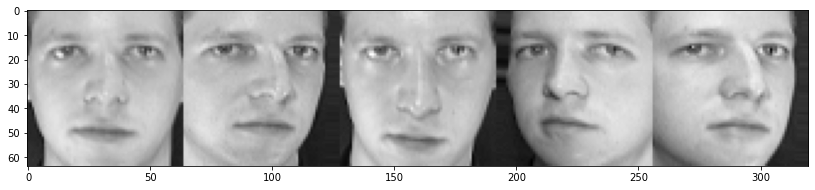

In [45]:
plt.figure(figsize=(14, 10))

plt.imshow(np.hstack(faces[:5].reshape(5, 64, 64)), cmap='gray')
plt.show()


In [46]:
# for numerical reasons we normalize the dataset
mean = faces.mean(axis=0)
std = faces.std(axis=0)
faces_normalized = (faces - mean) / std

The data for the basis has been saved in a file named `eigenfaces.npy`, first we load it into the variable B.

In [60]:
B = np.load('eigenfaces.npy')[:500]

print("the eigenfaces have shape {}".format(B.shape))

the eigenfaces have shape (100, 64, 64)


Each instance in $\boldsymbol B$ is a `64x64' image, an "eigenface", which we determined using an algorithm called Principal Component Analysis. Let's visualize 
a few of those "eigenfaces".

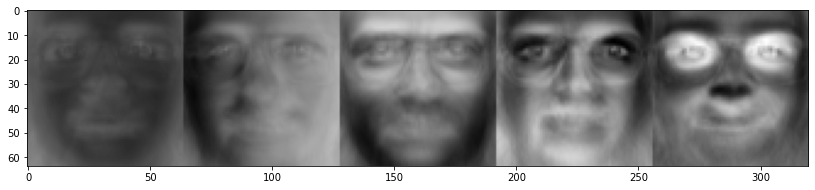

In [61]:
plt.figure(figsize=(14, 10))

plt.imshow(np.hstack(B[:5].reshape(-1, 64, 64)), cmap='gray');

#### Next, we'll take a look at what happens if we project our faces onto the basis $\boldsymbol B$ spanned by the "eigenfaces". 

In order to do this, we need to reshape $\boldsymbol B$ from above, which is of size (n, 64, 64), into size (4096, n). Here 4096 is the dimensionality of the data and n is the number of data points. 

Then we can reuse the functions we implemented earlier to compute the projection matrix and the projection.

In [68]:
@interact(i=(0, 50), ndims=(1, 500))
def show_face_face_reconstruction(i, ndims=1):
    original_face = faces_normalized[i].reshape(64, 64)
    # reshape the data we loaded in variable `B` 
    # so that we have a matrix representing the basis.
    B_basis = B.reshape(B.shape[0], 4096).T
    face_reconstruction = project_general(faces_normalized[i], B_basis[:, :ndims]).reshape(64, 64)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(np.hstack([original_face, face_reconstruction]), cmap='gray')
    plt.show()
    

interactive(children=(IntSlider(value=25, description='i', max=50), IntSlider(value=1, description='ndims', ma…